# Recommendations with IBM

In this notebook, I will be putting my recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, I will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
[References](#References)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df['article_id']=df['article_id'].astype('str') # changing article_id to type string
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content['article_id']=df_content['article_id'].astype('str') # changing article_id to type string
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

The dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
interactions_by_user =df.groupby(['email']).size() #interactions grouped by user, returns a Series with number of interactions each user had
interactions_by_user.sort_values(ascending=False, inplace=True)
interactions_by_user.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
dtype: int64

In [4]:
df_interactions_by_user = df.groupby(['email', 'article_id']).size().reset_index(name='interactions') #interactions grouped by user and article id, returns a DataFrame with a number of interaction a user had wit a specific article
df_interactions_by_user.sort_values(['interactions'], ascending=False, inplace=True)
df_interactions_by_user.head()

,email,article_id,interactions
3063,1588af175b283915f597fc4719cbb2c8621c4fc2,1170.0,42
7393,363cb98a087e4a3eb6890fd1af2d418116f85ff8,1170.0,41
5886,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,1429.0,35
16124,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,1429.0,35
26842,c8afd6f4620184042cc48ca0eba9a657ac89e90e,1429.0,25


In [5]:
# Fill in the median and maximum number of user_article interactios below
median_val = interactions_by_user.median() #3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =interactions_by_user.max() #364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content_grouped = df_content.groupby(['article_id']).size().reset_index(name='counts') #returns DataFrame grouped by article_id with number of times each articles occurres
duplicate_article_id = df_content_grouped['article_id'][df_content_grouped['counts']>1].tolist() # returns list of article ids that occur more than once in the content datafram
duplicate_article_id

['221', '232', '398', '50', '577']

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content_cleaned = df_content.drop_duplicates(['article_id'], keep='first', inplace=False)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
df_interactions_by_article = df.groupby([ 'article_id', 'title']).size().reset_index(name='interactions') #interactions grouped by article id, returns a DataFrame with a number of interaction an article had assocciated with it
df_interactions_by_article.sort_values(['interactions'], ascending=False, inplace=True)
df_interactions_by_article.head()

,article_id,title,interactions
311,1429.0,use deep learning for image classification,937
232,1330.0,insights from new york car accident reports,927
314,1431.0,visualize car data with brunel,671
309,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
261,1364.0,predicting churn with the spss random tree alg...,627


In [9]:
unique_articles = df_interactions_by_article[df_interactions_by_article['interactions']>=1].count()[0] #714 # The number of unique articles that have at least one interaction
total_articles = df_content_cleaned['article_id'].count() #1051# The number of unique articles on the IBM platform
unique_users = interactions_by_user.count() #5148# The number of unique users
user_article_interactions = df_interactions_by_article['interactions'][df_interactions_by_article['interactions']>=1].sum() #45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [10]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
df_interactions_by_article = df.groupby([ 'article_id']).size().reset_index(name='interactions') #interactions grouped by article id, returns a DataFrame with a number of interaction an article had assocciated with it
df_interactions_by_article.sort_values(['interactions'], ascending=False, inplace=True)
df_interactions_by_article.head()

,article_id,interactions
311,1429.0,937
232,1330.0,927
314,1431.0,671
309,1427.0,643
261,1364.0,627


In [12]:
df_interactions_by_article['article_id'][df_interactions_by_article['interactions']==df_interactions_by_article['interactions'].max()].item() #]['article_id']

'1429.0'

In [13]:
most_viewed_article_id = df_interactions_by_article['article_id'][df_interactions_by_article['interactions']==df_interactions_by_article['interactions'].max()].item() #'1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df_interactions_by_article['interactions'].max() #937# The most viewed article in the dataset was viewed how many times?

In [14]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below to returns the **n** top articles ordered with most interactions as the top. The function can be tested using the tests below.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    df_interactions_by_article = df.groupby([ 'article_id', 'title']).size().reset_index(name='interactions') #interactions grouped by article id, returns a DataFrame with a number of interaction an article had assocciated with it
    df_interactions_by_article.sort_values(['interactions'], ascending=False, inplace=True) 
    articles = df_interactions_by_article['title'].tolist() #returns a list of article titles sorted by the number of interactions
    top_articles = articles[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_interactions_by_article = df.groupby([ 'article_id', 'title']).size().reset_index(name='interactions') #interactions grouped by article id, returns a DataFrame with a number of interaction an article had assocciated with it
    df_interactions_by_article.sort_values(['interactions'], ascending=False, inplace=True) 
    articles = df_interactions_by_article['article_id'].tolist() #returns a list of article ids sorted by the number of interactions
    top_articles = articles[:n]
    return top_articles # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [17]:
# Tests the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Tests each of the three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below to reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then a value 1is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then a zero value is placed where the user-row meets for that article-column**. 

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item = df[['user_id', 'article_id']]
    user_item = user_item.groupby(['user_id', 'article_id']).size().reset_index(name='interactions')
    user_item = user_item.groupby(['user_id', 'article_id'])['interactions'].max().unstack()
    user_item = user_item.notnull().astype('int') #replacing NaN vlaues with 0 and not NaN values with 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [19]:
## Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users. 

In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_list = user_item.T.columns.tolist() #returns a list of all user ids
    
    similarity = dict()
    for user in user_list: # returns a dot product of user_id and every other user and saves it to a dictionary element
        similar = user_item.T[user_id].dot(user_item.T[user])
        similarity[user] = similar

    # sort by similarity
    similarity_sorted = dict(sorted(similarity.items(), key=lambda x: x[1], reverse=True))

    # create list of just the ids
    most_similar_users = list(similarity_sorted.keys())
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [21]:
# a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  The functions below to returns the articles we would recommend to each user.

In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    df_temp= df.drop_duplicates(['article_id'],keep='first', inplace=False)
    article_dict= dict(zip(df_temp.article_id, df_temp.title)) #returns dictionary of article ids and titles

    article_names = [article_dict[x] for x in article_ids]
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = list(user_item.loc[user_id].loc[lambda x : x!=0].keys()) # returns a list of article ids by extracting user_id row from user_item DataFrame and filtering out 0 values
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    most_similar_users = find_similar_users(user_id)
    read_articles = get_user_articles(user_id)[0]
    possible_recs = []

    for user in most_similar_users:
        articles = get_user_articles(user)[0] # removing the articles our user_id has already read
        possible_recs +=[item for item in articles if item not in read_articles and item not in possible_recs]
        if len(possible_recs)>m:
            break
            
    
    try:
        recs = possible_recs[:m]
    
    except:
        diff = m - len(all_recs) # difference between number of wanted recommendations and the recomm from similar users
        popular_articles = get_top_article_ids(m)
        recs = possible_recs + [item for item in popular_articles if item not in read_articles and item not in possible_recs][:diff]
        
    return recs # return your recommendations for this user_id    

In [23]:
## Test
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [24]:
## Tests
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we will choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function from earlier.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    user_list = user_item.T.columns.tolist() #returns a list of all user ids
    user_list.remove(user_id)
    
    interactions_by_user =df.groupby(['user_id']).size() #interactions grouped by user, returns a Series with number of interactions each user had
    interactions_by_user.drop(interactions_by_user.index[user_id])
    
    neighbors_df = pd.DataFrame(user_list, columns = ['neighbor_id']) # defining a DataFrame with user_list as an index column
    neighbors_df = neighbors_df.set_index('neighbor_id')
                            
    for user in user_list: 
        similar = user_item.T[user_id].dot(user_item.T[user])# returns a dot product of user_id and every other user and saves it to a DataFrame column
        neighbors_df.at[user, 'similarity'] = similar

    neighbors_df['num_interactions'] = interactions_by_user                         

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    try:
        top_sorted_users = get_top_sorted_users(user_id) # if the user is brand new, the function returns top m articles
    except:
        recs = get_top_article_ids(m)
        rec_names = get_article_names(recs)
        return recs, rec_names
    
    
    read_articles = get_user_articles(user_id)[0]
    possible_recs = []

    for user in top_sorted_users.index.tolist():
        articles = get_user_articles(user)[0] # removing the articles our user_id has already read
        possible_recs +=[item for item in articles if item not in read_articles and item not in possible_recs]
        if len(possible_recs)>m:
            break
            
    
    try:
        recs = possible_recs[:m]
    
    except:
        diff = m - len(all_recs) # difference between number of wanted recommendations and the recomm from similar users
        top_articles = get_top_article_ids(m)
        recs = possible_recs + [item for item in top_articles if item not in read_articles and item not in possible_recs][:diff]
    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [26]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` The functions from above are now used to correctly fill in the solutions to the dictionary below

In [27]:
## Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)[:1].index[0] #3933# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)[9:10].index[0]# 242# Find the 10th most similar user to user 131

In [28]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?

For new users that don't have any interactions with the content available on the platform, the simplest way to make recommendations is to suggest the most popular items (**rank-based recommendations**) which can be done using *'get_top_article_ids'* function.

Even though the rank-based recommendation might be the simplest solution to the visitor cold start problem, it is far from perfect because it is generalised based on all of the user-item interactions and is not able to customise the recommendations (all new users would get the same recommendations). In order to personalise the recommendations for brand new visitors, we can resort to their geolocation and other contextual information  like the device operating system, browser or domain they came from. Recommendation of trending products can be used to break the ice and based on the first couple of interactions, we could resot to the **content-based recommendations** where the attributes of items are used to find similar items for recommendations. 

`7.` Using the existing functions, we can provide the top 10 recommended articles for the a new user below.

In [29]:
new_user = '0.0'
new_user_recs = get_top_article_ids(10)

In [30]:
## Test
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` I have already created a **user_item** matrix above in **question 1** of **Part III** above. The cells below will get things set up for the rest of **Part V** of the notebook. 

In [31]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [32]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  The cell below performs SVD.

In [33]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [34]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

We have no missing values in this matrix therefore we can perform SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  The cell below shows how the accuracy improves as we increase the number of latent features.

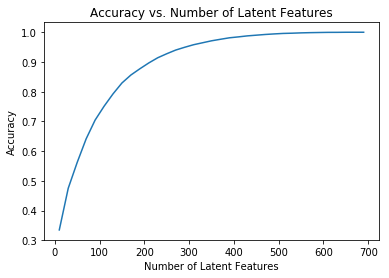

In [35]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We can use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [36]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = df_train[['user_id', 'article_id']]
    user_item_train = user_item_train.groupby(['user_id', 'article_id']).size().reset_index(name='interactions')
    user_item_train = user_item_train.groupby(['user_id', 'article_id'])['interactions'].max().unstack()
    user_item_train = user_item_train.notnull().astype('int')
    
    user_item_test = df_test[['user_id', 'article_id']]
    user_item_test = user_item_test.groupby(['user_id', 'article_id']).size().reset_index(name='interactions')
    user_item_test = user_item_test.groupby(['user_id', 'article_id'])['interactions'].max().unstack()
    user_item_test = user_item_test.notnull().astype('int')
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [37]:
train_users = set(user_item_train.index.tolist())
test_users = set(user_item_test.index.tolist())
train_arts = set(user_item_train.columns.tolist())
test_arts = set(user_item_test.columns.tolist())

def same_items (list1, list2):
   list_same= [i for i in list1 if i in list2]#+ list2 if i not in list1 or i not in list2]
   return list_same

In [38]:
len(same_items(train_users, test_users))

20

In [39]:
len(test_users)- len(same_items(train_users, test_users))

662

In [40]:
len(same_items(train_arts, test_arts))

574

In [41]:
len(test_arts)- len(same_items(train_arts, test_arts))

0

In [42]:
##Tests
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d, # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now we can use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

The cells below explore how well SVD works towards making predictions for recommendations on the test data.  

In [43]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [44]:
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [45]:
s_train.shape

(714,)

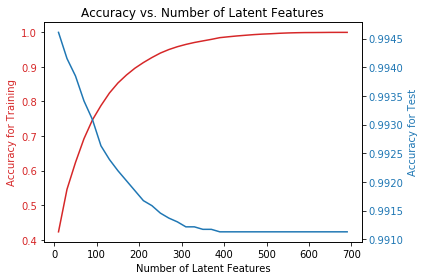

In [46]:

num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []


#Decomposition
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

users_can_predict = np.intersect1d(list(user_item_train.index),list(user_item_test.index))

for k in num_latent_feats:
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :] #reshaping U, Sigma and Vt matrices to correct shape
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new)) # returns dot products
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    diffs_train = np.subtract(user_item_train, user_item_train_preds) # returns error for each prediction
    diffs_test = np.subtract(user_item_test.loc[users_can_predict,:], user_item_test_preds)
    
    err_train = np.sum(np.sum(np.abs(diffs_train))) #returns total error
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Accuracy for Training', color=color)
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Accuracy vs. Number of Latent Features')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy for Test', color=color)
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

The accuracy for the training data increases with an increase in the number of latent features, however the opposite is true for the accuracy of the test data. It's worth noting that SVD can only make recommendations for the 20 users in both the training and test dataset and a sparse matrix is likely the reason why the test data accuracy is so high at >99%.

To test how well this recommendation engine works in practice, we could conduct an A/B test for new users to help solve the cold start problem. This way  we would recommend articles to one group using the recommendation engine and to other group recommend just the most popular articles. We would then compare the click through rates to measure if our recommendation engine leads to an increase in clicks. If we saw a significant rise in clicks by using the SVD recommendation engine then we could conclude this works well and should be deployed.

### <a class="anchor" id="References">References</a>

1. [Pandas documentation](https://pandas.pydata.org/docs/index.html)

2. [Using SVD for dimensionality reduction](https://blogs.oracle.com/machinelearning/post/using-svd-for-dimensionality-reduction)

3. [Comparison of python lists](https://www.stechies.com/compare-lists-python-using-set-cmp-function/)

4. [numpy.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

5. [Recommender System — singular value decomposition (SVD) & truncated SVD](https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361#:~:text=Singular%20value%20decomposition%20(SVD)%20is%20a%20collaborative%20filtering%20method%20for,factor%20model%20for%20matrix%20factorization)

6. [Cold start problem](https://www.yusp.com/blog-posts/cold-start-problem/)


In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0